# Datos Censales a Nivel Individual

Por [**Eduardo Graells-Garrido** (@carnby)](https://twitter.com/carnby), <egraells@udd.cl>

Los microdatos del [Censo 2017](http://www.censo2017.cl/) se pueden obtener visitando las oficinas del Instituto Nacional de Estadísticas y pedirlos en un DVD. O bien los puedes bajar desde [Google Drive](https://drive.google.com/drive/u/1/folders/12qIuycAHmXPDwqmtz4PB_ozfj1Wd9Zjn) cortesía del [Centro de Investigación del Arvo Shanpion](https://mobile.twitter.com/CIAS_Chile).

A diferencia de otros notebooks en este repositorio, los microdatos son demasiado grandes para subirlos a un repositorio de GitHub, así que este notebook requiere que bajes los datos en formato CSV y los almacenes en una carpeta. En el caso de mi computador, esa carpeta es `/home/egraells/Descargas/Census2017`.

Por _demasiado grandes_ me refiero a que superan el límite de almacenamiento impuesto por GitHub. Por ejemplo, el archivo `Microdatr_Censo2017-Personas.csv` pesa 2.2 Gigabytes. Quizás en un computador más o menos moderno se puedan cargar estos datos en memoria RAM, pero es probable que no se pueda, a fin de cuentas, también usamos programas grandes, navegadores, escuchamos música, etc. 

Por eso en este notebook utilizaremos otra herramienta que permite analizar datos que incluso no caben en la memoria. Y, al mismo tiempo, permite hacer procesamiento en paralelo, aprovechando la cantidad de núcleos que tengan nuestras máquinas. Esta herramienta se llama [Dask](https://dask.pydata.org/en/latest/) y se construye sobre `pandas`, así que si sabemos algo de `pandas` también sabemos algo de `dask` :)

Como preguntas para analizar tendremos las siguientes:

  * ¿De dónde provienen les inmigrantes?
  * ¿Existen diferencias entre los tiempos de llegada al país dependiendo del origen?
  * ¿Existen diferencias en los destinos dentro de Chile donde residen, dependiendo del origen?

## Preámbulo

In [1]:
import pandas as pd
import dask.dataframe as dd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', font='Linux Biolinum O', context='poster', palette='viridis')
%config InlineBackend.figure_format='retina'

In [3]:
pd.set_option('display.max_columns', None)

## Carguemos los Datos

In [4]:
census = dd.read_csv('/home/egraells/Descargas/Census2017/Microdato_Censo2017-Personas.csv', sep=';')
census.head()

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,ID_ZONA_LOC,NVIV,NHOGAR,PERSONAN,P07,P08,P09,P10,P10COMUNA,P10PAIS,P11,P11COMUNA,P11PAIS,P12,P12COMUNA,P12PAIS,P12A_LLEGADA,P12A_TRAMO,P13,P14,P15,P15A,P16,P16A,P16A_OTRO,P17,P18,P19,P20,P21M,P21A,P10PAIS_GRUPO,P11PAIS_GRUPO,P12PAIS_GRUPO,ESCOLARIDAD,P16A_GRUPO
0,15,152,15202,1,2,6,13225,1,1,1,1,1,73,1,98,998,3,15101,998,1,98,998,9998,98,2,4,6,2,1,2,98,7,98,98,98,98,9998,998,998,998,4,2
1,15,152,15202,1,2,6,13225,3,1,1,1,1,78,1,98,998,2,98,998,1,98,998,9998,98,3,98,98,98,1,2,98,7,98,98,98,98,9998,998,998,998,0,2
2,15,152,15202,1,2,6,13225,3,1,2,2,2,78,1,98,998,2,98,998,1,98,998,9998,98,3,98,98,98,1,2,98,7,98,1,1,3,1965,998,998,998,0,2
3,15,152,15202,1,2,6,13225,3,1,3,5,2,52,1,98,998,2,98,998,1,98,998,9998,98,1,2,5,2,1,2,98,7,98,2,1,4,1995,998,998,998,2,2
4,15,152,15202,1,2,6,13225,3,1,4,11,1,44,1,98,998,2,98,998,1,98,998,9998,98,1,3,5,2,1,2,98,1,Z,98,98,98,9998,998,998,998,3,2


In [5]:
len(census)

17574003

## ¿De dónde provienen les inmigrantes?

In [6]:
migrant_origins = census.groupby('P12PAIS_GRUPO').size().compute()

Noten la diferencia con `pandas`: hay un método `compute()` que le dice a `dask` que ejecute el cálculo. A diferencia de `pandas`, en esta biblioteca _no_ se ejecutan las tareas de manera inmediata. Esto le permite a `dask` agrupar tareas y planear una estrategia de cálculo (recordemos que los datos no están en la memoria RAM, y que además utilizará procesamiento en paralelo).

In [7]:
migrant_origins

P12PAIS_GRUPO
2          1722
5         27040
9          2250
13        11269
21        16191
29        19781
32        73867
68        77503
142       21654
150       50612
170      108001
218       28612
332       64567
604      192082
862       85461
997        4073
998    16471743
999      317575
dtype: int64

Vemos, por ejemplo, que la opción 998 ("No Aplica") es 16471743. Es decir, esa es la cantidad de personas chilenas. Pero, ¿cómo identificar los otros códigos? Debemos traducirlos o decodificarlos con un archivo auxiliar que viene en el dataset. Como es un archivo pequeño lo podemos cargar con `pandas` sin preocupación:

In [8]:
country_codes = pd.read_csv('/home/egraells/Descargas/Census2017/Censo2017_Etiquetas_Persona/Etiquetas_Persona_PAIS_GRUPO.csv', sep=';', index_col='valor')
country_codes

,glosa
valor,
2,África
5,Sudamérica
9,Oceanía
10,Antártida
13,Centroamérica
21,Norteamérica
29,Caribe
32,Argentina
68,Bolivia (Estado Plurinacional de)


Lo que necesitamos ahora es _unir_ ambas fuentes de datos a través del índice en común que tienen: el código de la respuesta a la pregunta `P12`. Aprovecharemos de eliminar las opciones que no nos interesan: 997, 998 y 999.

In [9]:
migrant_origins = (pd.DataFrame(migrant_origins)
                   .drop([997, 998, 999], axis=0)
                   .join(country_codes).set_index('glosa'))
migrant_origins

,0
glosa,
África,1722
Sudamérica,27040
Oceanía,2250
Centroamérica,11269
Norteamérica,16191
Caribe,19781
Argentina,73867
Bolivia (Estado Plurinacional de),77503
Asia,21654


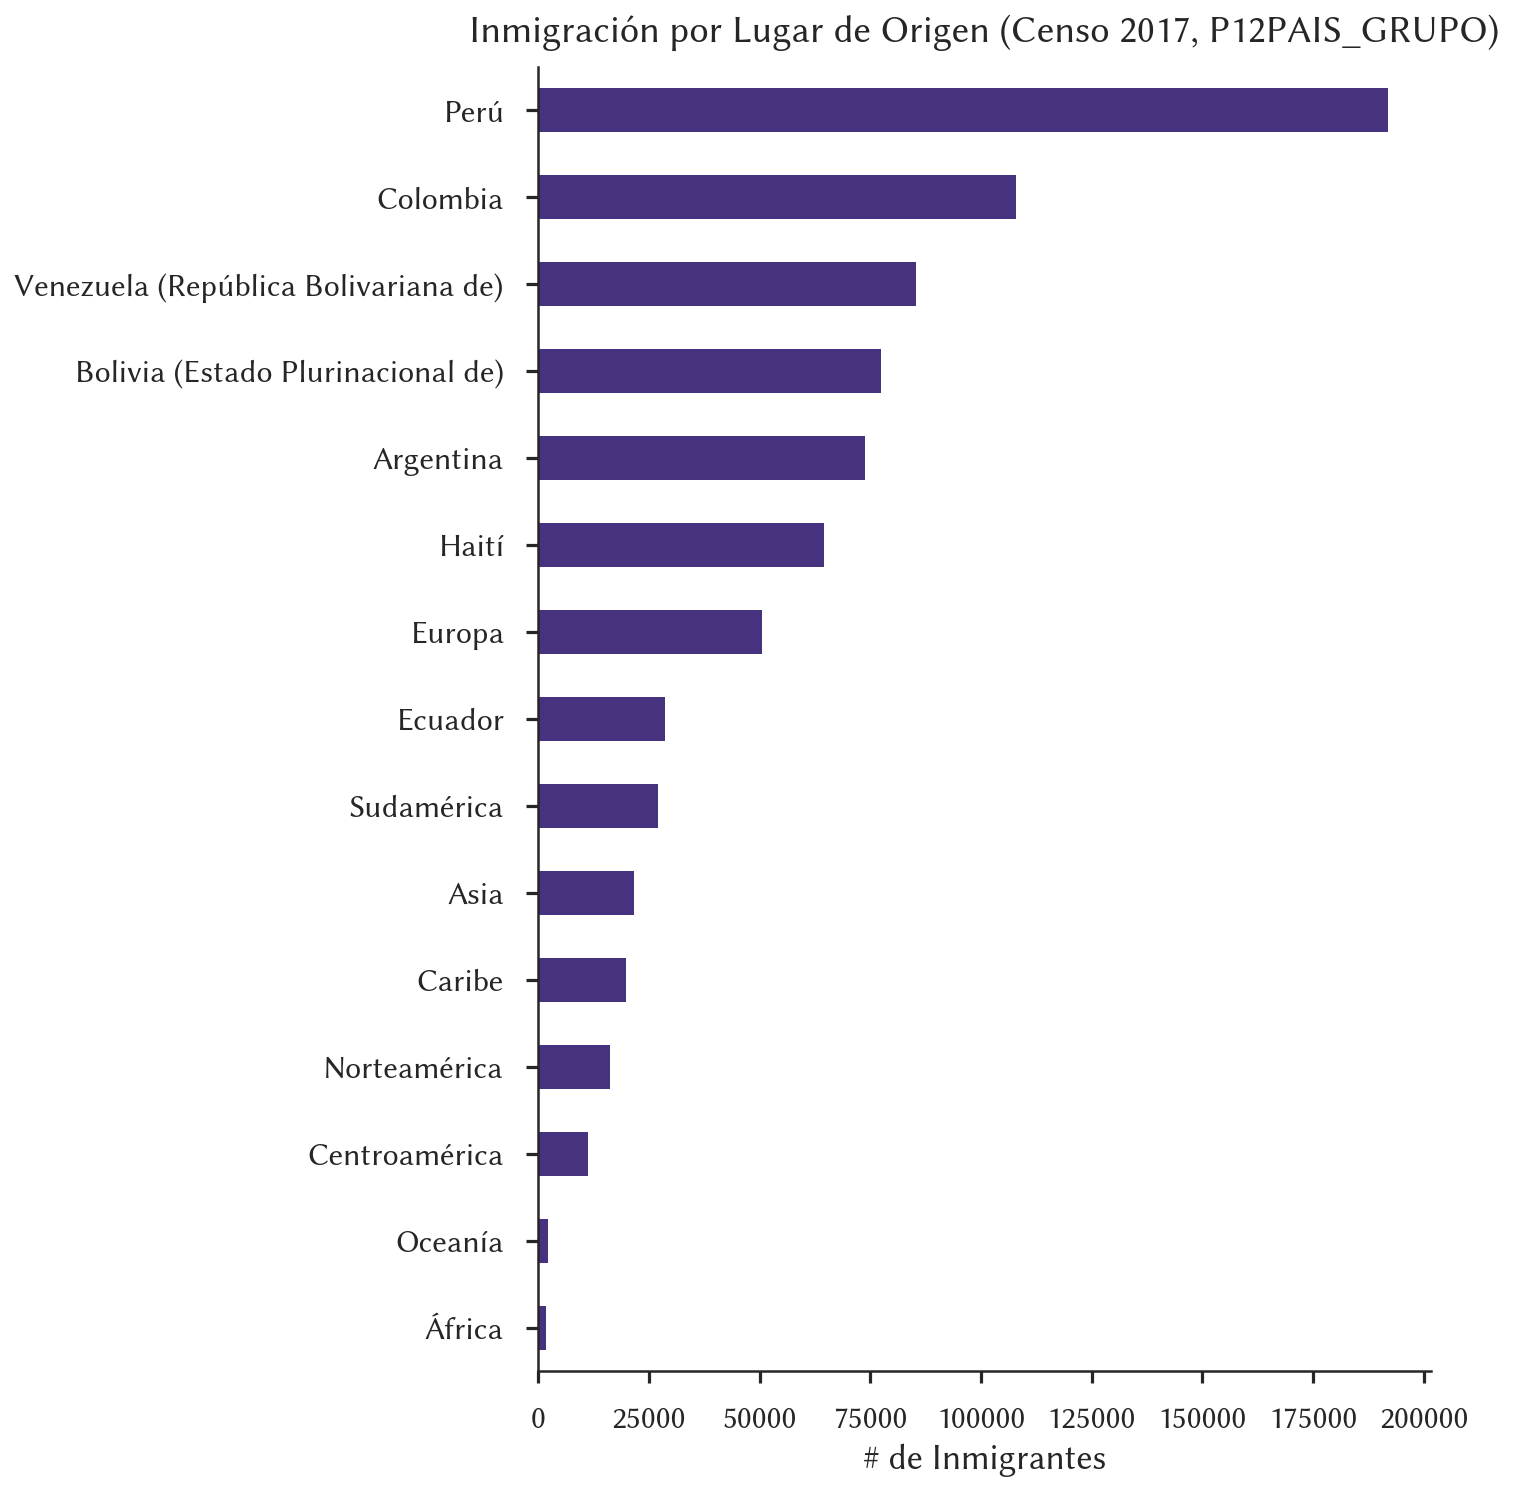

In [10]:
migrant_origins.sort_values(0).plot(kind='barh', figsize=(8,12), legend=False)
plt.xlabel('# de Inmigrantes')
plt.ylabel('')
plt.title('Inmigración por Lugar de Origen (Censo 2017, P12PAIS_GRUPO)', y=1.01)
sns.despine()
plt.savefig('migrant_count_per_country.png', dpi=150, bbox_inches='tight')

## ¿Existen diferencias entre los tiempos de llegada al país dependiendo del origen?

Realizaremos un procedimiento similar, pero esta vez agruparemos por dos variables: agregamos el año de llegada al país.

In [11]:
migrant_year_counts = census.groupby(['P12PAIS_GRUPO', 'P12A_LLEGADA']).size().compute()

In [12]:
migrant_year_counts.sample(10)

P12PAIS_GRUPO  P12A_LLEGADA
997            1995              14
332            2007              56
32             2000            1471
9              1985              14
170            1958              10
32             1996            1356
997            1959               3
218            1970              11
13             1987              59
150            1974             162
dtype: int64

In [13]:
year_counts = pd.DataFrame(migrant_year_counts.reset_index().set_index('P12PAIS_GRUPO')).join(country_codes).rename(columns={0: 'n_individuals', 'P12A_LLEGADA': 'year', 'glosa': 'origin'})
year_counts.head()

,year,n_individuals,origin
2,1991,24,África
2,2014,94,África
2,2016,193,África
2,2017,164,África
2,9999,339,África


Con esta tabla quiséramos construir series temporales que nos ayuden a ver los patrones de llegada en la inmigración (notemos que hay valores inválidos, como año 9999):

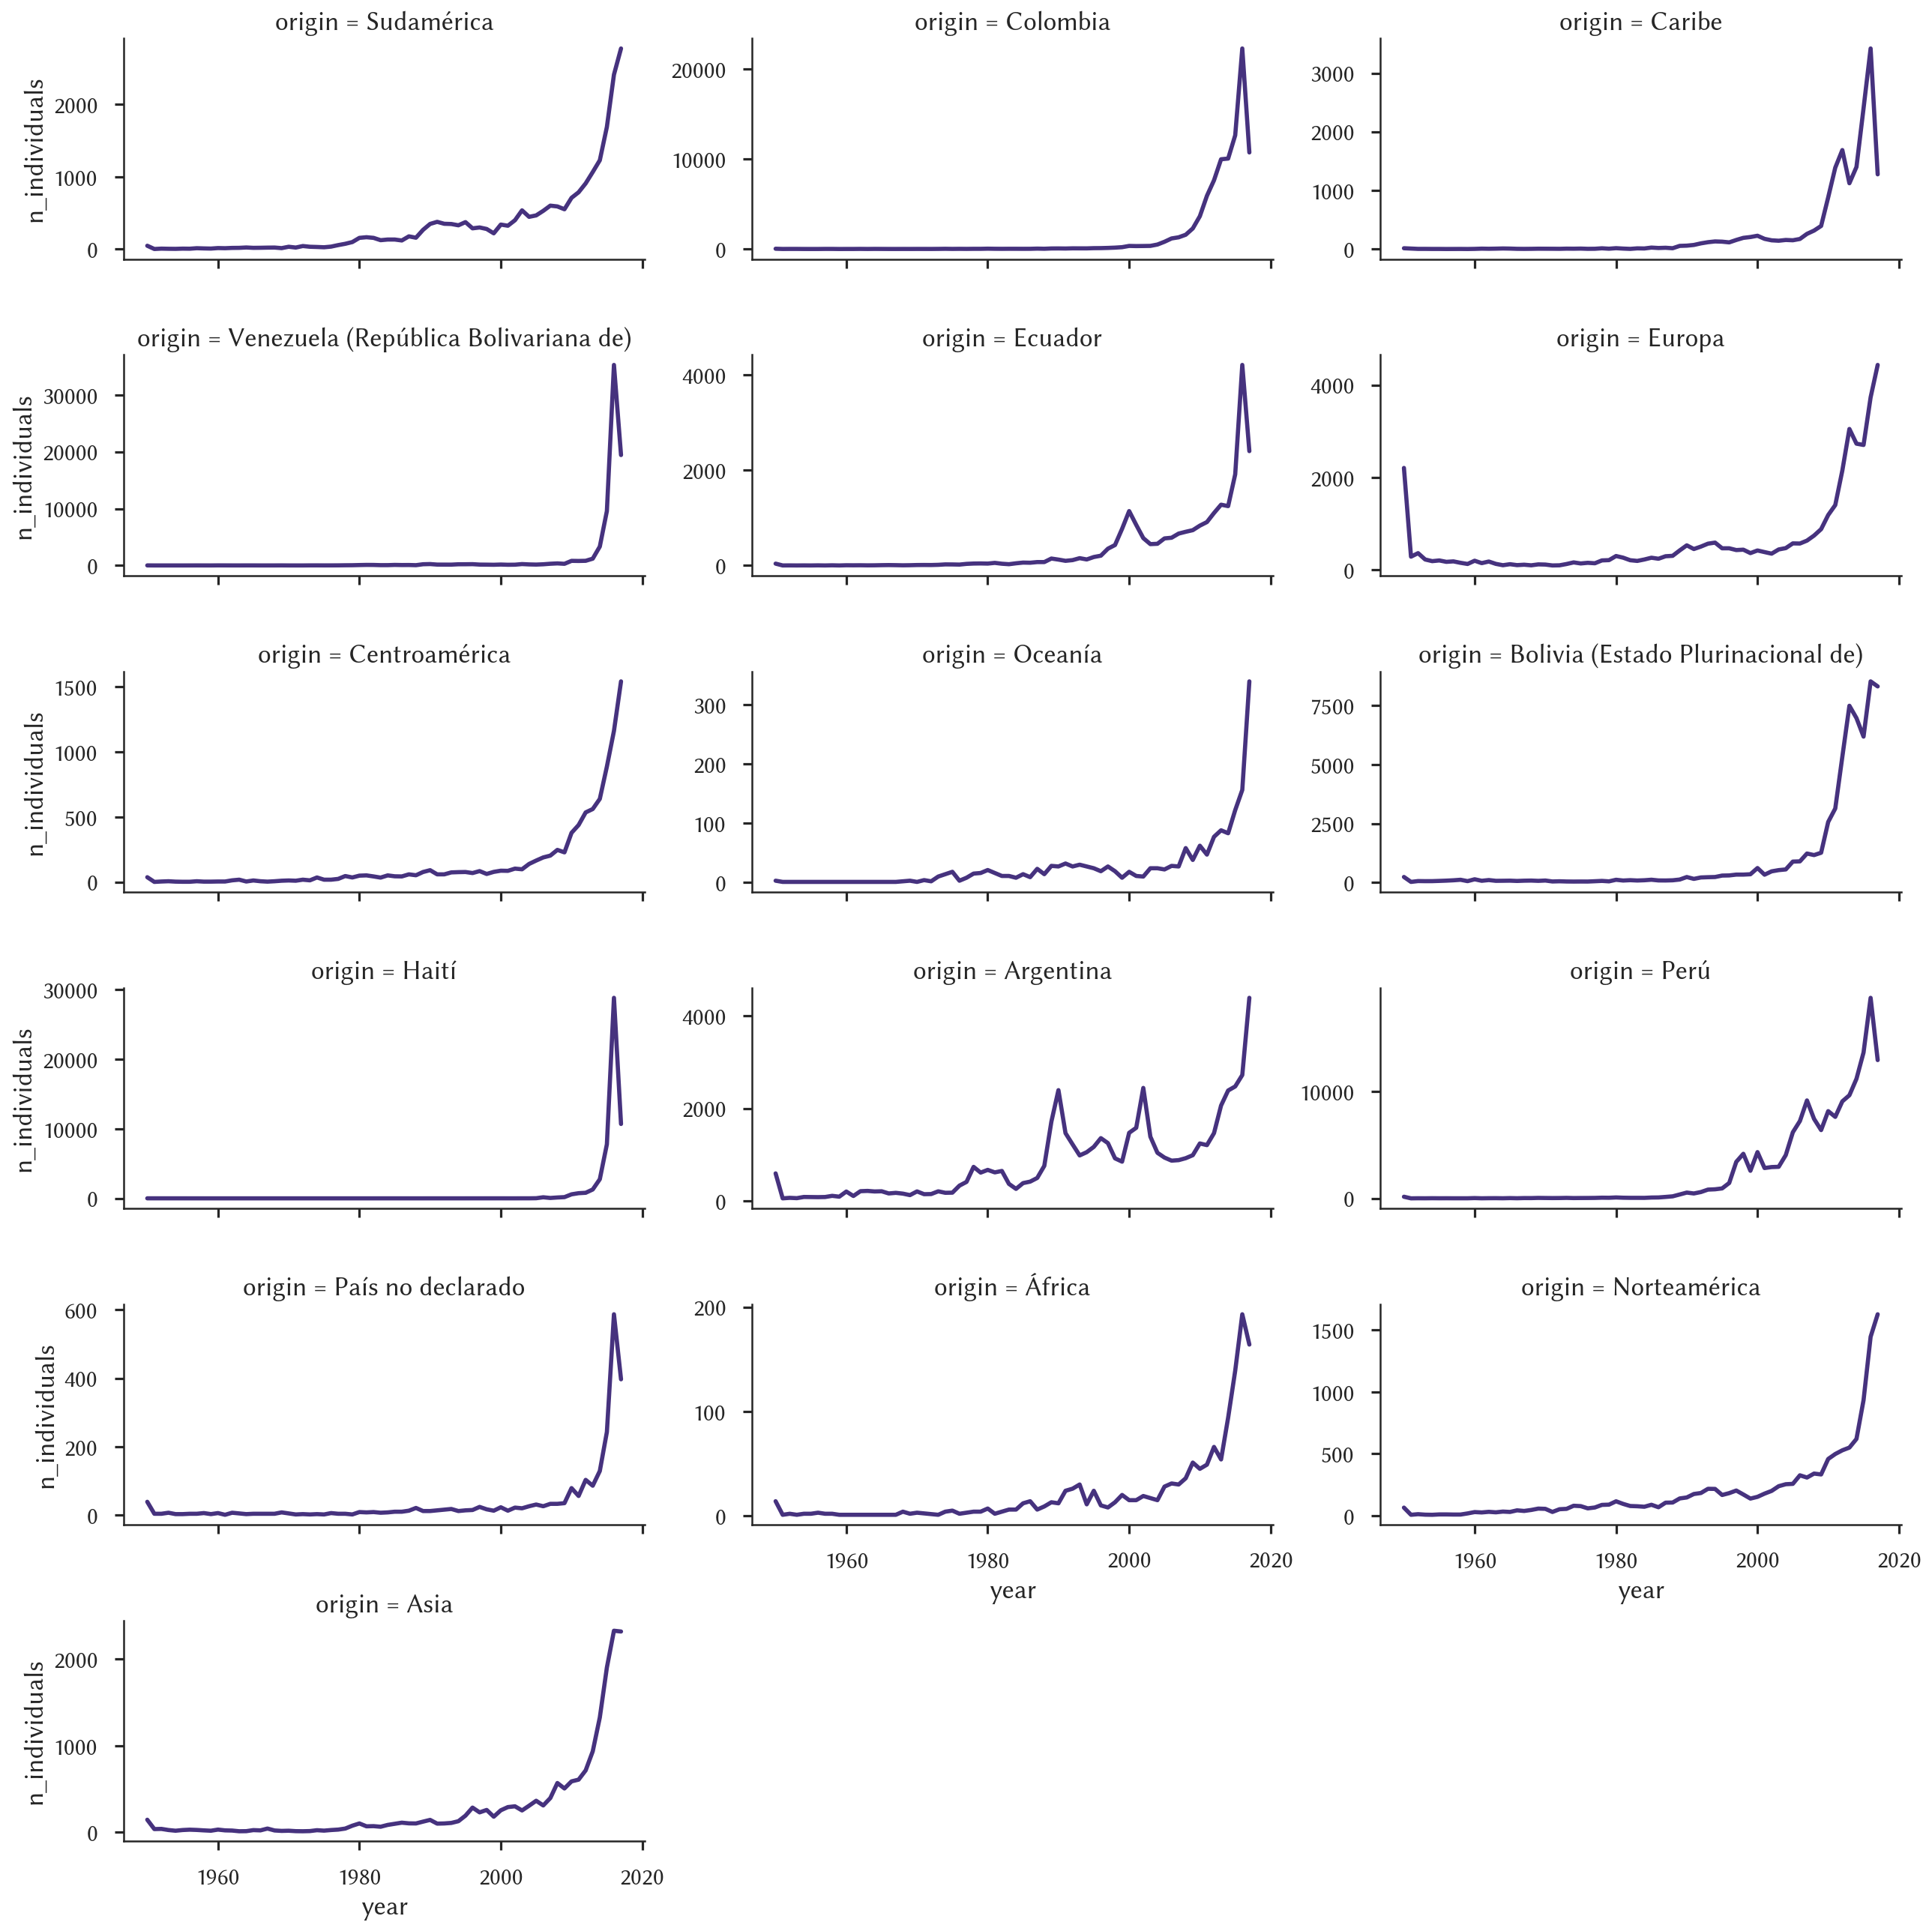

In [14]:
g = sns.FacetGrid(data=year_counts[year_counts.year <= 2017].sort_values('year'), col='origin', col_wrap=3, sharey=False, size=3, aspect=2)
g.map(plt.plot, 'year', 'n_individuals')
plt.savefig('migrant_series.png', dpi=150, bbox_inches='tight')

¡Qué interesante! Podemos ver patrones _por origen_, sin embargo, cuesta tener una visión global y comparar entre orígenes, puesto que la cantidad por cada uno es distinta. Para eso podemos construir una matriz que luego normalizaremos por filas, de modo que el año que cada origen tenga su máximo de inmigración tenga valor 1:

In [15]:
def flatten_columns(df):
    df.columns = df.columns.levels[1]
    return df

year_series = (year_counts.pivot(index='origin', columns='year')
               .pipe(flatten_columns)
               .fillna(0)
               .pipe(lambda x: x.div(x.max(axis=1), axis=0))
               .drop([9998, 9999], axis=1)
               .drop(['Missing', 'No aplica', 'País no declarado'], axis=0)
              )

year_series

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
origin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.032438,0.002899,0.003501,0.003118,0.004540,0.004431,0.004321,0.004486,0.005853,0.004868,0.010940,0.005689,0.011378,0.011706,0.011050,0.011269,0.008698,0.009409,0.008479,0.006728,0.011104,0.007822,0.007986,0.011214,0.009463,0.009627,0.017942,0.022373,0.040151,0.033368,0.036595,0.033641,0.035337,0.020021,0.014113,0.020951,0.022701,0.027023,0.041354,0.093649,0.131010,0.080083,0.066791,0.053717,0.057546,0.063837,0.074175,0.068268,0.050271,0.046332,0.080466,0.086429,0.133636,0.075926,0.056835,0.051146,0.047536,0.048137,0.050435,0.053990,0.067885,0.065915,0.080083,0.112795,0.130573,0.135386,0.148898,0.240304
Asia,0.037751,0.009633,0.010154,0.006769,0.004686,0.006769,0.007810,0.007029,0.005728,0.004686,0.008071,0.005728,0.005207,0.003124,0.003385,0.006509,0.005728,0.011195,0.005467,0.004166,0.004686,0.003385,0.003124,0.003645,0.006248,0.004947,0.006769,0.008071,0.011195,0.019787,0.026556,0.017964,0.018485,0.016662,0.022130,0.025514,0.028899,0.026816,0.026556,0.032023,0.037230,0.026035,0.026556,0.028118,0.033325,0.049987,0.074199,0.059880,0.067170,0.046863,0.066129,0.075762,0.078105,0.065608,0.079927,0.094767,0.080708,0.102838,0.148139,0.131737,0.153085,0.158292,0.186149,0.243426,0.345223,0.495444,0.606092,0.603749
Bolivia (Estado Plurinacional de),0.015852,0.001932,0.004263,0.003996,0.004063,0.004729,0.005462,0.006461,0.007926,0.004063,0.009325,0.005062,0.007127,0.004929,0.005129,0.005395,0.004596,0.005328,0.005661,0.004862,0.005795,0.003130,0.003663,0.003064,0.002864,0.002997,0.002931,0.003796,0.004729,0.003463,0.007926,0.005795,0.006794,0.005861,0.006594,0.008059,0.006061,0.005928,0.006461,0.008592,0.015652,0.010457,0.014453,0.015186,0.015719,0.019782,0.020181,0.022512,0.022512,0.023511,0.041028,0.022313,0.031704,0.035167,0.037099,0.059211,0.059877,0.081990,0.077594,0.084188,0.171040,0.209005,0.355002,0.498934,0.464100,0.411882,0.567737,0.553550
Caribe,0.004094,0.000000,0.000877,0.000877,0.000585,0.000585,0.000292,0.000000,0.000585,0.000292,0.000877,0.002047,0.001462,0.002047,0.002924,0.002339,0.001170,0.000877,0.001170,0.001754,0.000000,0.001462,0.001170,0.002047,0.001754,0.002339,0.001170,0.001462,0.003801,0.001754,0.004386,0.002339,0.000877,0.003509,0.002924,0.007310,0.005263,0.006433,0.004094,0.015789,0.016959,0.020468,0.028363,0.034211,0.038012,0.036842,0.033333,0.045322,0.055848,0.059942,0.066374,0.050877,0.043567,0.041520,0.045322,0.043860,0.050292,0.075731,0.092105,0.115205,0.257895,0.405848,0.493567,0.328070,0.409357,0.701754,1.000000,0.372515
Centroamérica,0.018734,0.000506,0.002025,0.003038,0.001519,0.001013,0.001013,0.003038,0.001519,0.001519,0.002025,0.002025,0.006582,0.009114,0.002025,0.006076,0.003038,0.001519,0.003038,0.005063,0.006076,0.005063,0.009114,0.006582,0.017722,0.009114,0.009114,0.012152,0.023291,0.017722,0.024810,0.025823,0.021772,0.017215,0.025823,0.022278,0.021772,0.029873,0.026329,0.038987,0.046076,0.029873,0.029873,0.037468,0.038481,0.038987,0.034937,0.042532,0.031392,0.039494,0.044051,0.043544,0.052152,0.049620,0.070380,0.083544,0.095696,0.102785,0.125063,0.115443,0.191392,0.221772,0.270886,0.284051,0.323544,0.449114,0.587848,0.780759
Colombia,0.001392,0.000225,0.000449,0.000449,0.000180,0.000090,0.000135,0.000494,0.000449,0.000045,0.000225,0.000225,0.000539,0.000225,0.000539,0.000404,0.000225,0.000180,0.000314,0.000269,0.000404,0.000359,0.000314,0.000584,0.001033,0.000539,0.000853,0.000584,0.000943,0.000943,0.001661,0.001123,0.000898,0.001123,0.001078,0.000943,0.001033,0.001976,0.001257,0.002694,0.002874,0.002470,0.003368,0.003233,0.003188,0.004266,0.004535,0.005478,0.006870,

Lo bueno de usar una matriz es que podemos organizar sus filas para poner las que más se parezcan entre sí en posiciones cercanas. Se hace así:

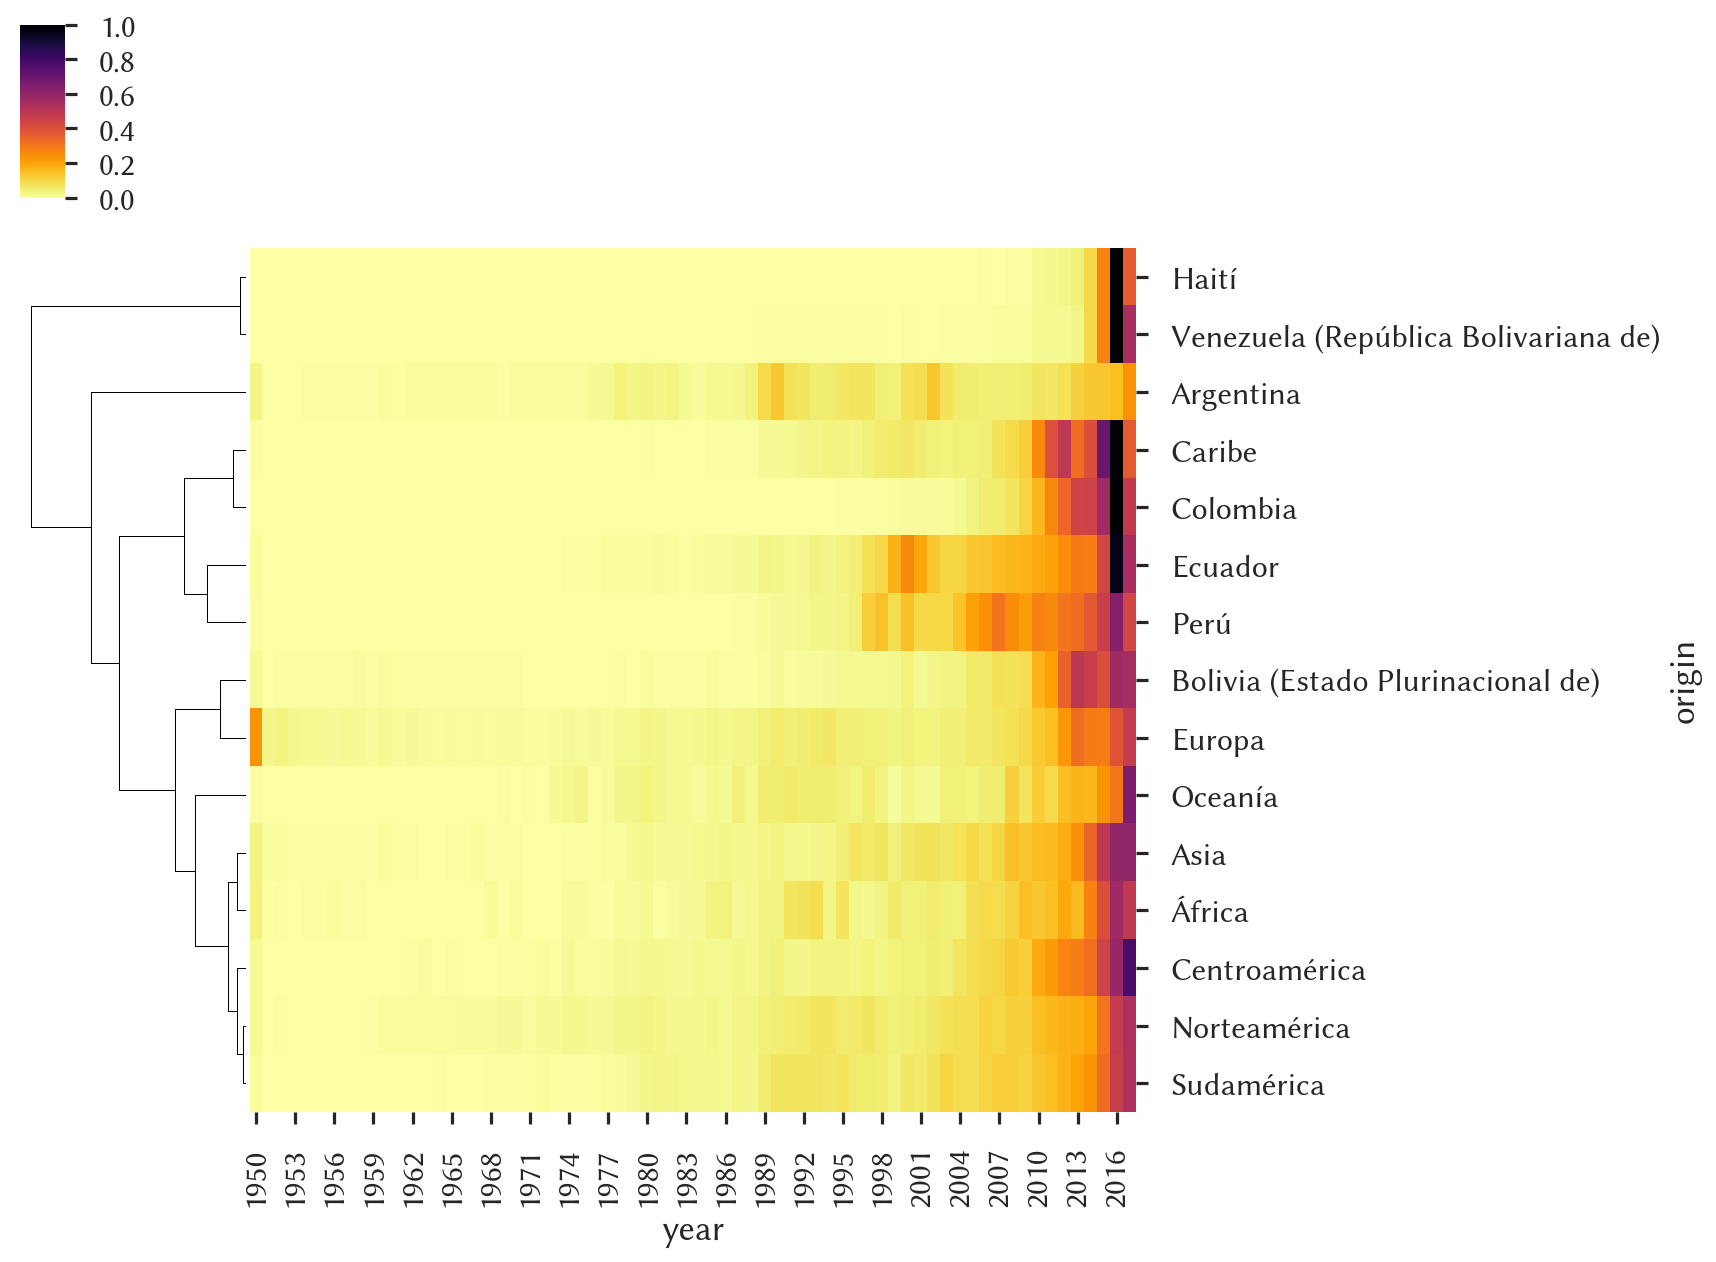

In [16]:
g = sns.clustermap(year_series, col_cluster=False, metric='correlation', method='ward', cmap='inferno_r')

El gráfico anterior no me gusta tanto, así que prefiero hacerlo de nuevo pero sin los indicadores de clustering. Podemos aprovechar que el clustering queda guardado en la variable `g`.

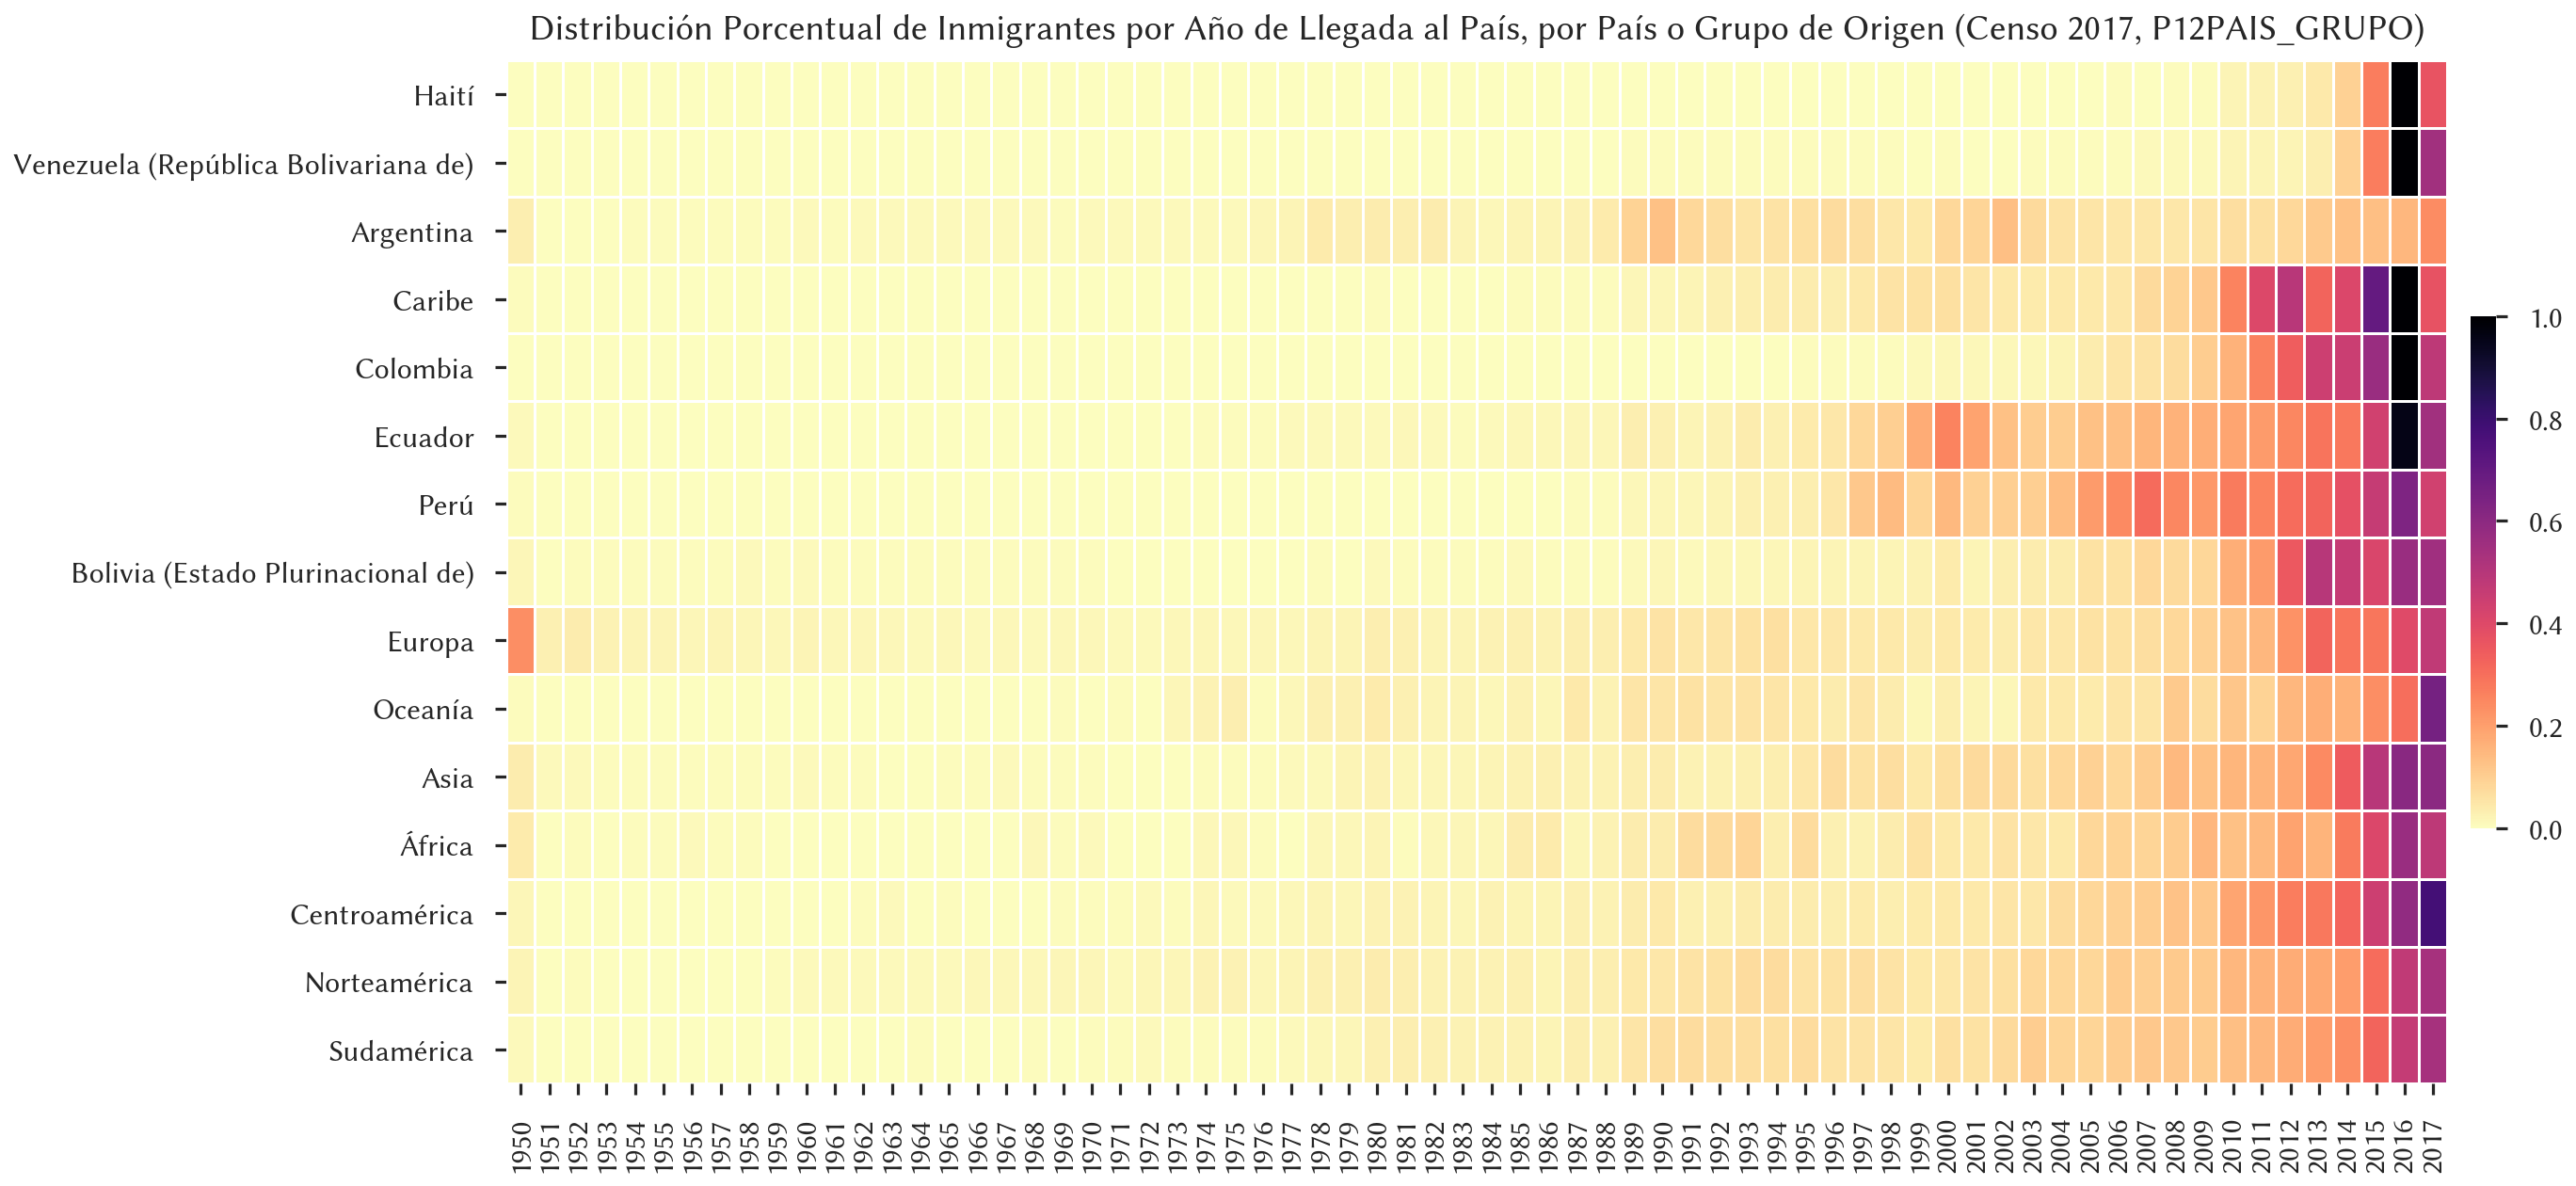

In [17]:
plt.figure(figsize=(22, 10))
sns.heatmap(g.data2d, cmap='magma_r', linewidth=1, cbar_kws=dict(shrink=0.5, pad=0.01), xticklabels=True)
plt.title('Distribución Porcentual de Inmigrantes por Año de Llegada al País, por País o Grupo de Origen (Censo 2017, P12PAIS_GRUPO)', y=1.01)
plt.ylabel('')
plt.xlabel('')
plt.savefig('migrant_matrix.png', dpi=150, bbox_inches='tight')

## ¿Existen diferencias en los destinos dentro de Chile donde residen, dependiendo del origen?

Haremos un procedimiento similar al de la pregunta anterior. 

In [18]:
migrant_reg_counts = census.groupby(['P12PAIS_GRUPO', 'REGION']).size().compute()
migrant_reg_counts.sample(5)

P12PAIS_GRUPO  REGION
604            8          1459
13             12          207
21             13        10074
9              15           17
218            12           79
dtype: int64

In [19]:
region_names = pd.read_csv('/home/egraells/Descargas/Census2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Regiones.csv', sep=';', index_col='REGION')
region_names

,NOM_REGION
REGION,
1,TARAPACÁ
2,ANTOFAGASTA
3,ATACAMA
4,COQUIMBO
5,VALPARAÍSO
6,LIBERTADOR BERNARDO O’HIGGINS
7,MAULE
8,BIOBÍO
9,ARAUCANÍA


Al igual que en el paso anterior, haremos una matriz. La diferencia es que antes aplicábamos una normalización por filas. Ahora aplicaremos una [_estandarización_](https://en.wikipedia.org/wiki/Standard_score) por columnas.

In [20]:
migrants_per_region = (migrant_reg_counts.reset_index()
 .pipe(lambda x: x.pivot(index='P12PAIS_GRUPO', columns='REGION'))
 .drop([997, 998, 999], axis=0)
 .pipe(flatten_columns)
 .pipe(lambda x: x.T.join(region_names).set_index('NOM_REGION').T)
 .join(country_codes)
 .set_index('glosa')
 .apply(lambda x: (x - x.mean()) / x.std(), axis=0)
)

migrants_per_region

,TARAPACÁ,ANTOFAGASTA,ATACAMA,COQUIMBO,VALPARAÍSO,LIBERTADOR BERNARDO O’HIGGINS,MAULE,BIOBÍO,ARAUCANÍA,LOS LAGOS,AYSÉN,MAGALLANES,METROPOLITANA,LOS RÍOS,ARICA Y PARINACOTA
glosa,,,,,,,,,,,,,,,
África,-0.505273,-0.548204,-0.686591,-1.038315,-1.111525,-1.255800,-1.181142,-1.120712,-0.520270,-0.578731,-0.531924,-0.792811,-0.851236,-0.612513,-0.455826
Sudamérica,-0.364469,-0.383278,-0.504819,-0.425785,-0.261496,-0.314913,-0.306406,-0.022103,-0.171960,-0.208484,-0.265482,0.182911,-0.426268,-0.241490,-0.385941
Oceanía,-0.505107,-0.548333,-0.686591,-1.044566,-1.062668,-1.231040,-1.206040,-1.144785,-0.492432,-0.543194,-0.499519,-0.671066,-0.844261,-0.622277,-0.453417
Centroamérica,-0.484444,-0.516735,-0.509421,-0.848723,-0.770719,-0.943547,-0.850834,-0.487152,-0.384476,-0.445673,-0.449111,-0.514033,-0.686645,-0.326923,-0.433105
Norteamérica,-0.486111,-0.517248,-0.616413,-0.718508,-0.298437,-0.807366,-0.681530,-0.512319,-0.283989,-0.304352,-0.114258,-0.019997,-0.614180,-0.209758,-0.417958
Caribe,-0.430955,-0.503248,-0.508270,-0.550791,-0.821164,-0.829375,-0.649993,-0.710375,-0.390587,-0.434103,-0.362697,-0.134684,-0.485203,-0.475821,-0.402121
Argentina,-0.322811,-0.271015,-0.091806,0.851362,2.514998,1.253233,1.554274,2.489159,3.516189,3.430346,3.396294,2.787189,0.064820,3.251495,-0.332236
Bolivia (Estado Plurinacional de),2.952678,2.601450,2.611760,0.391964,-0.408464,0.046861,-0.658292,-0.732260,-0.426572,-0.502698,-0.474315,-0.757523,-0.482176,-0.458734,2.481076
Asia,-0.159178,-0.460089,-0.505969,-0.696632,-0.625340,-0.841755,-0.674891,-0.498094,-0.322690,-0.331624,-0.510320,0.661068,-0.518316,-0.324482,-0.421744


Esta vez si nos interesa ver el clustering, para poder identificar grupos de países o de regiones que tengan comportamiento similar.

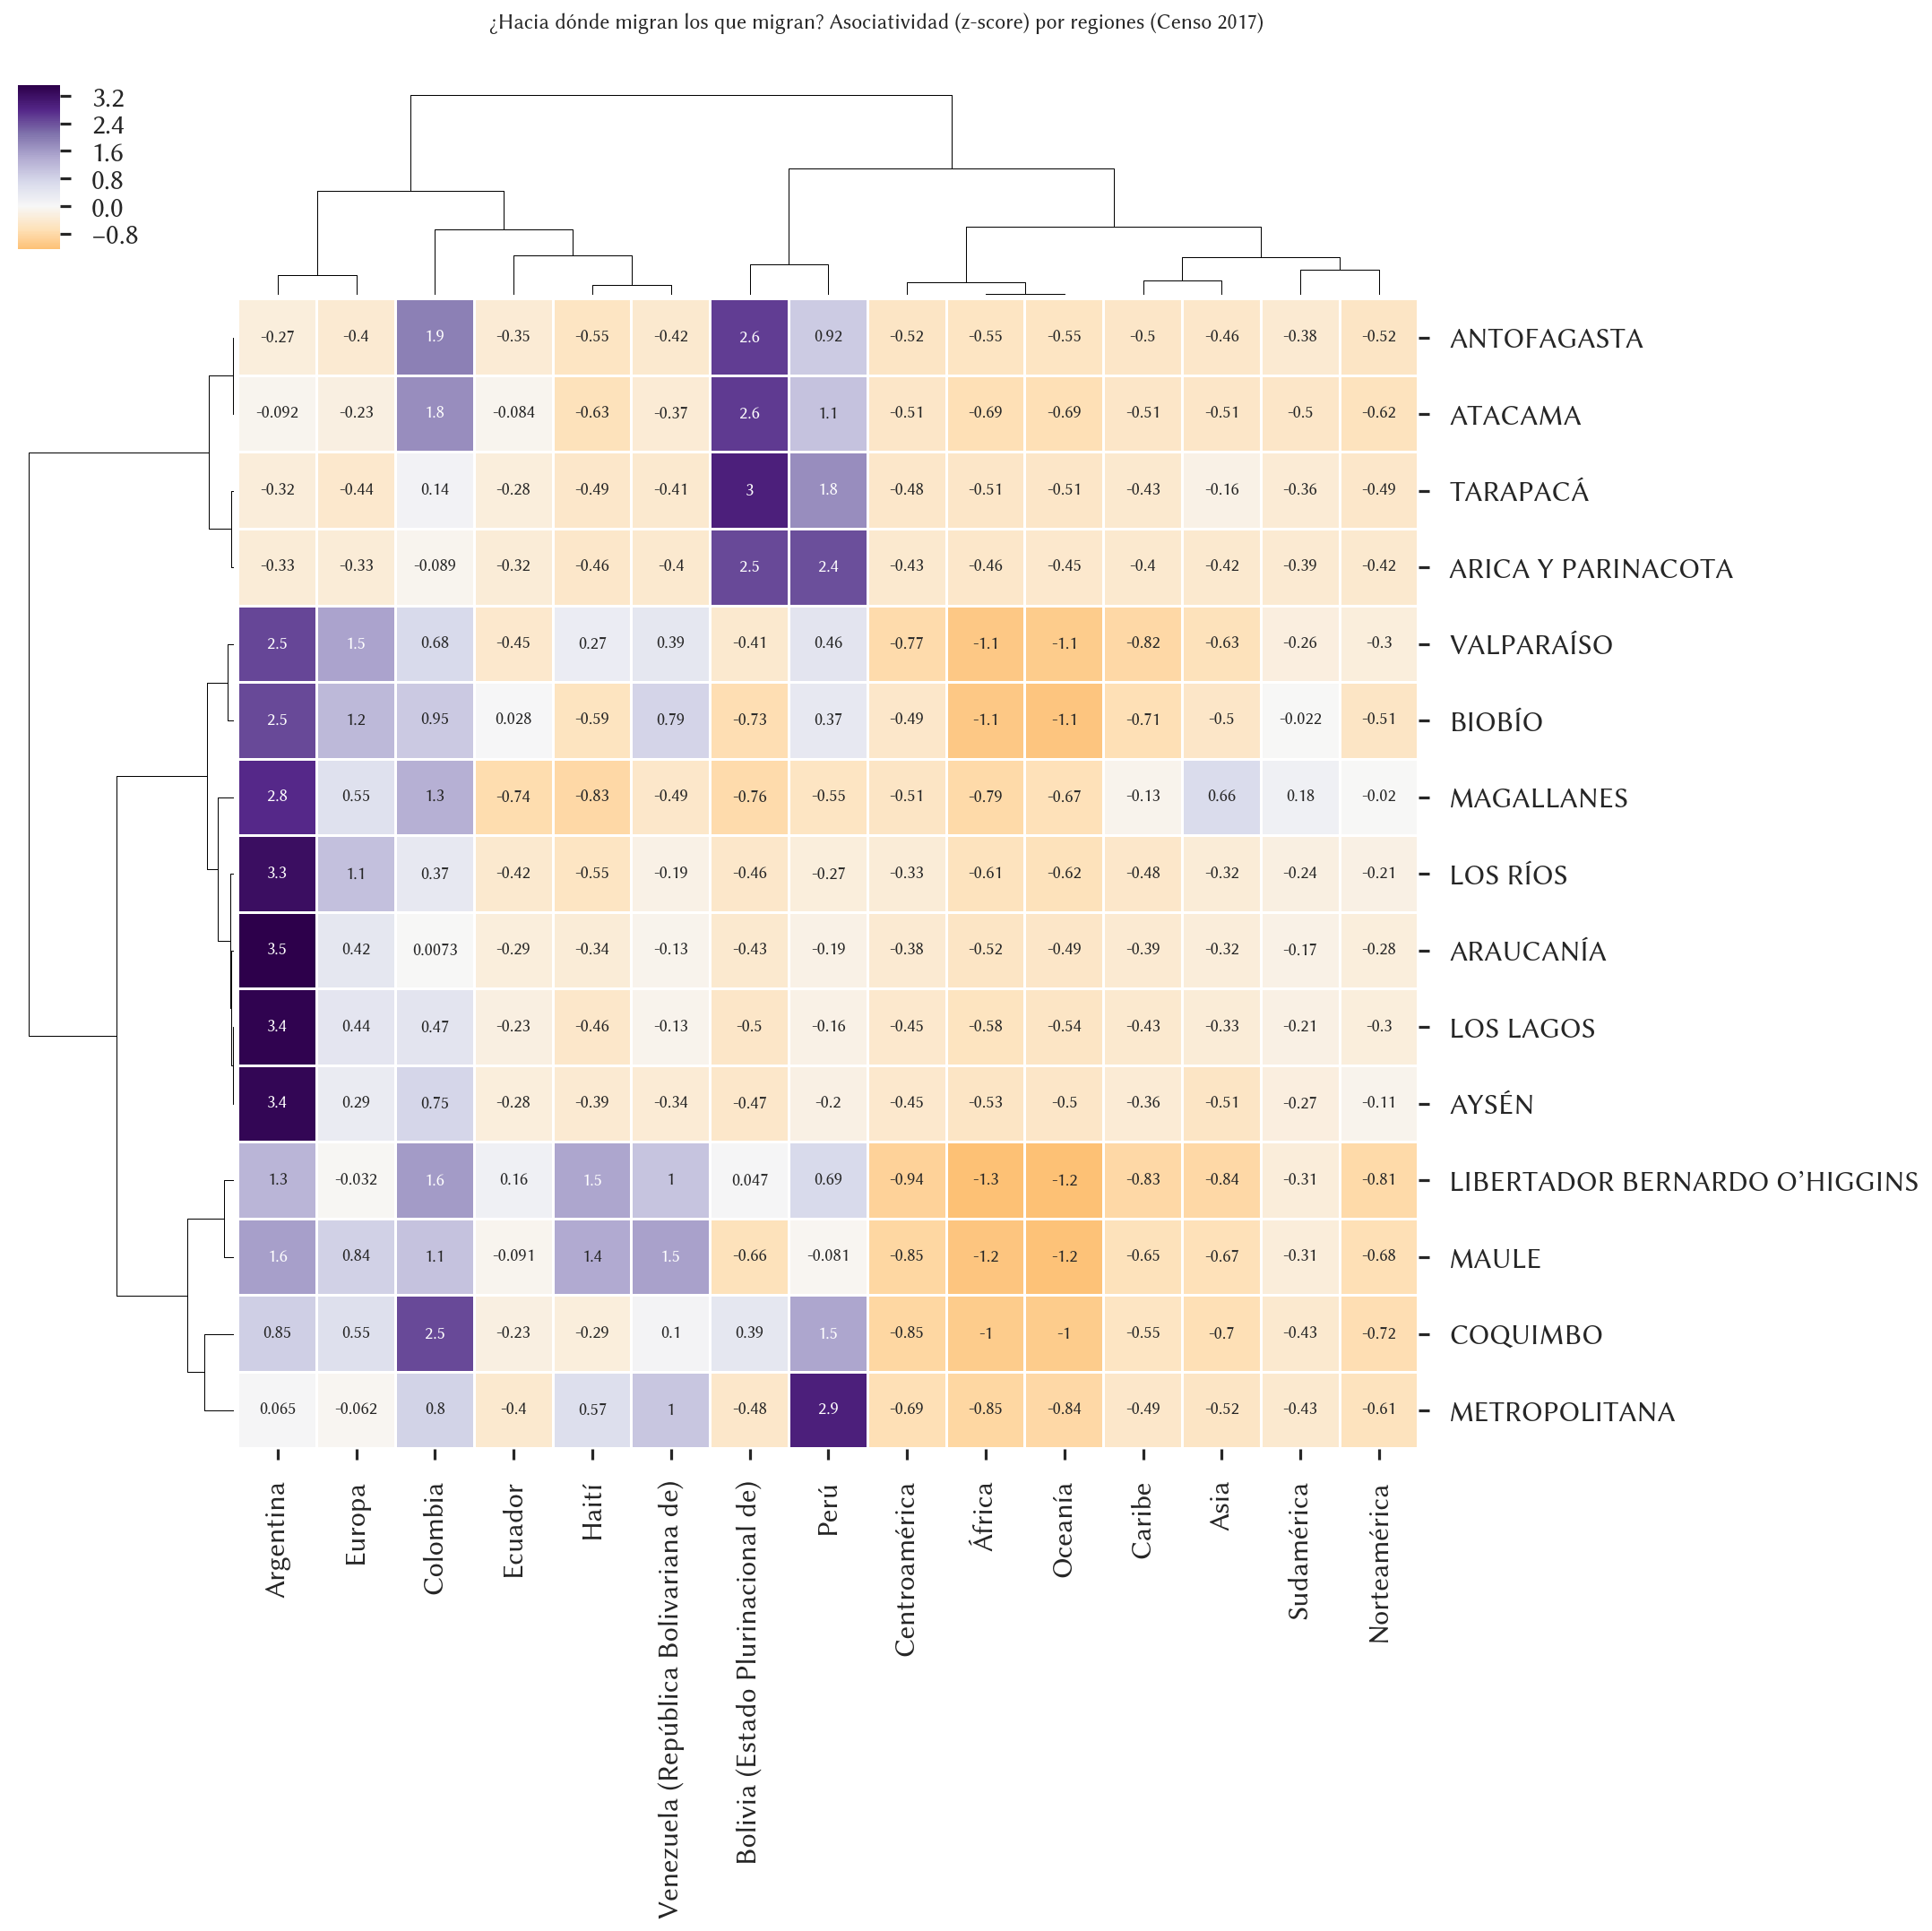

In [21]:
g = sns.clustermap(migrants_per_region.T, center=0, cmap='PuOr', annot=True, figsize=(14,14), linewidth=1, method='ward', metric='correlation')
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.suptitle('¿Hacia dónde migran los que migran? Asociatividad (z-score) por regiones (Censo 2017)', y=0.92, x=0.6);
g.savefig('migrants_per_region_z.png', dpi=150, bbox_inches='tight')

# Fin

Con esto cerramos el ejemplo. Todavía hay cosas por hacer, por ejemplo, controlar por población en la última pregunta. Aún así, con esto ya tienes una buena base para hacer tus propias preguntas y realizar un análisis exploratorio. 

No dudes en contactarme con sugerencias, correcciones y preguntas. El conocimiento es libre y solamente lo podemos hacer crecer entre todes :)